Found cached dataset parquet (C:/Users/HououinKyouma/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

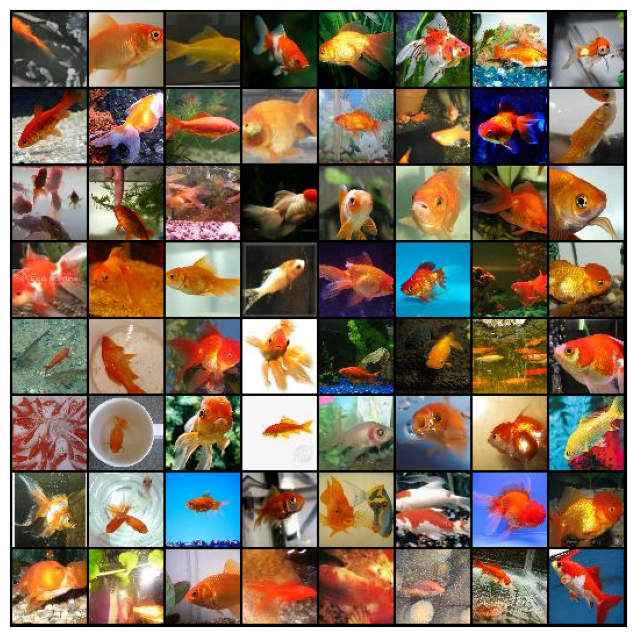

In [7]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from dataset import Dataset
from configuration import config

batch_size = config.dataloader.batch_size
ds = Dataset.load(**config.dataset)
dataloader = ds.dataloader(**config.dataloader, type='train')

def denormalize(images):
  return images * 0.5 + 0.5

def show_images(images):
  figure, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

def show_batch(dataloader):
  for (images, _) in dataloader:
    images = images.detach()[:64]

    show_images(denormalize(images))
    break

show_batch(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


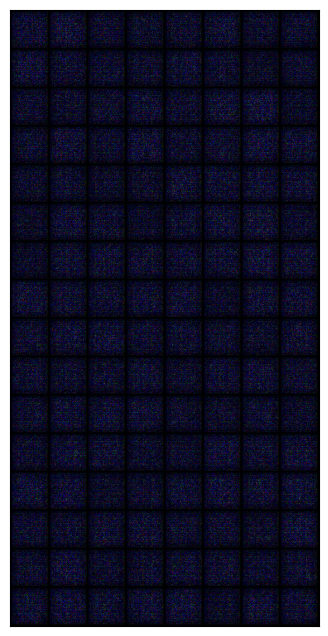

In [8]:
from discriminator import Discriminator
from generator import Generator
from weights import initialize_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)
generator = Generator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)

latent_size = 128
noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
noise_images = generator(noises)

show_images(noise_images.cpu())

In [9]:
from torch.nn import BCELoss
def save_samples(index, noises, show=True):
  images = generator(noises)

  filename = f'output-images-{index:0=4d}.png'
  save_image(denormalize(images), os.path.join(output_directory, filename), nrow=8)
  print(f'Saving {filename}')

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1, 2, 0))

criterion = BCELoss()

def train_discriminator(images, optimizer):
  optimizer.zero_grad()

  images_predictions = discriminator(images)
  images_targets = torch.ones(images.size(0), 1, device=device)
  images_targets = images_targets * 0.9

  images_loss = criterion(images_predictions, images_targets)
  images_score = torch.mean(images_predictions).item()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  noises_targets = torch.zeros(noises_images.size(0), 1, device=device)
  noises_targets = noises_targets + 0.1

  noises_predictions = discriminator(noises_images)
  noises_loss = criterion(noises_predictions, noises_targets)
  noises_score = torch.mean(noises_predictions).item()

  loss = images_loss + noises_loss
  loss.backward()
  optimizer.step()

  return loss.item(), images_score, noises_score

def train_generator(optimizer):
  optimizer.zero_grad()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  predictions = discriminator(noises_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = criterion(predictions, targets)

  loss.backward()
  optimizer.step()

  return loss.item()

def fit(discriminator, generator, dataloader, epochs, learning_rate):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []
  images_scores = []
  noises_scores = []
  fid_scores = []

  optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images, _ in tqdm(dataloader):
      images = images.to(device)

      loss_discriminator, images_score, noises_score = train_discriminator(images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)

    losses_generator.append(loss_generator)
    losses_discriminator.append(loss_discriminator)

    images_fid = images[:8].type(torch.uint8).cpu()
    noises_fid = generator(noises[:8]).type(torch.uint8).cpu()
    fid = FrechetInceptionDistance(feature=2048)
    fid.update(images_fid, real=True)
    fid.update(noises_fid, real=False)
    fid_score = fid.compute()

    fid_scores.append(fid_score)
    images_scores.append(images_score)
    noises_scores.append(noises_score)

    print(
      f"Epoch [{epoch + 1}/{epochs}]"
      f" loss_generator: {loss_generator:.4f}"
      f" loss_discriminator: {loss_discriminator:.4f}"
      f" images_score: {images_score:.4f}"
      f" noises_score: {noises_score:.4f}"
      f" fid_score: {fid_score:.4f}"
    )

    save_samples(epoch, constant_noise, show=False)

  return losses_generator, losses_discriminator, images_scores, noises_scores, fid_scores


In [10]:
from torch.nn.functional import adaptive_avg_pool2d
from numpy.linalg import linalg
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance


In [ ]:
scales = [16, 32, 64, 128, 256]
learning_rate = 0.0002
epochs = 200

for generator_scale in scales:

  for discriminator_scale in scales:
    generator = (
      Generator(use_gpu=config.use_gpu, scale=generator_scale)
      .apply(initialize_weights)
      .to(device)
    )
    discriminator = (
      Discriminator(use_gpu=config.use_gpu, scale=discriminator_scale)
      .apply(initialize_weights)
      .to(device)
    )

    output_directory = f'results/{generator_scale}-{discriminator_scale}'
    model_directory = f'models/{generator_scale}-{discriminator_scale}'

    os.makedirs(output_directory, exist_ok=True)
    os.makedirs(output_directory, exist_ok=True)

    constant_noise = torch.randn(64, latent_size, 1, 1, device=device)
    save_samples(0, constant_noise)

    (
      losses_generator,
      losses_discriminator,
      images_scores,
      noises_scores,
      fid_scores
    ) = fit(
      discriminator,
      generator,
      dataloader,
      epochs=epochs,
      learning_rate=learning_rate
    )

    torch.save(generator.state_dict(), f'{model_directory}-generator.pt')
    torch.save(discriminator.state_dict(), f'{model_directory}-discriminator.pt')

    scores_directory = f'scores/{generator_scale}-{discriminator_scale}'
    os.makedirs(scores_directory, exist_ok=True)
    csv = open(f'{scores_directory}.csv', 'w')
    csv.write('loss_generator,loss_discriminator,images_score,noises_score,fid_score\n')
    for epoch in range(epochs):
      csv.write(
        f'{losses_generator[epoch]},{losses_discriminator[epoch]},{images_scores[epoch]},{noises_scores[epoch]},{fid_scores[epoch]}\n')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving output-images-0000.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/200] loss_generator: 1.3310 loss_discriminator: 1.2846 images_score: 0.5756 noises_score: 0.4609 fid_score: 245.2745
Saving output-images-0000.png


C:\Users\HououinKyouma\PycharmProjects\2023-wk\venv\lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:205: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/200] loss_generator: 1.6424 loss_discriminator: 1.0140 images_score: 0.6966 noises_score: 0.3609 fid_score: 312.6102
Saving output-images-0001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/200] loss_generator: 1.8308 loss_discriminator: 0.9857 images_score: 0.7051 noises_score: 0.3285 fid_score: 316.1920
Saving output-images-0002.png


  0%|          | 0/4 [00:00<?, ?it/s]